# Practical 1 - Motion Estimation

## Setup

### Import necessay libraries

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Import images

#### Utility functions

In [9]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def display_image(img: np.ndarray, title: str = "") -> None:
    """
    Display image with matplotlib
    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img)
    plt.title(title)
    plt.show()

#### Load images and display chosen samples

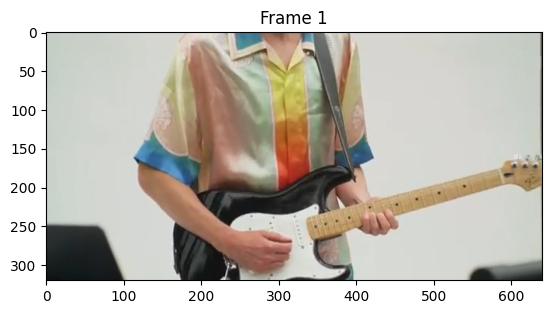

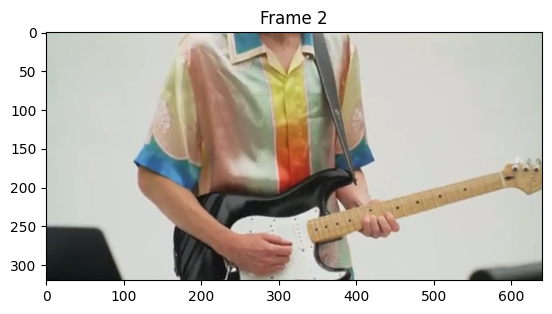

In [10]:
frame1: np.ndarray = load_image("./images/LF000.jpg")
display_image(frame1, "Frame 1")

frame2: np.ndarray = load_image("./images/LF001.jpg")
display_image(frame2, "Frame 2")

## A - Lucas-Kanade with colored images

### Traversal: Surrounding pixels

In [11]:
# Spatial gradient
def spatial_gradient(img: np.ndarray) -> tuple:
    """
    Compute spatial gradient of an image
    :param img: image to compute spatial gradient
    :return: spatial gradient
    """
    g_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    g_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    return g_x, g_y

# Temporal gradient
def temporal_gradient(img1: np.ndarray, img2: np.ndarray) -> np.ndarray:
    """
    Compute temporal gradient of two images
    :param img1: first image
    :param img2: second image
    :return: temporal gradient
    """
    return img2 - img1

In [12]:
# Compute optical flow
def optical_flow(frame1: np.ndarray, frame2: np.ndarray, window_size: int) -> np.ndarray:
    """
    Compute optical flow
    :param g_x: spatial gradient in x
    :param g_y: spatial gradient in y
    :param g_t: temporal gradient
    :return: optical flow
    """
    frame1_r = frame1[:, :, 0]
    frame1_g = frame1[:, :, 1]
    frame1_b = frame1[:, :, 2]

    frame2_r = frame2[:, :, 0]
    frame2_g = frame2[:, :, 1]
    frame2_b = frame2[:, :, 2]

    u = np.zeros((frame1.shape[0] * frame1.shape[1]))
    v = np.zeros((frame1.shape[0] * frame1.shape[1]))

    for i in range(frame1.shape[0]):
        for j in range(frame1.shape[1]):
            # Compute window min and max indices
            i_min = max(0, i - window_size)
            i_max = min(frame1.shape[0], i + window_size)
            j_min = max(0, j - window_size)
            j_max = min(frame1.shape[1], j + window_size)

            # Compute spatial gradient
            G_x_r, G_y_r = spatial_gradient(frame1_r[i_min:i_max, j_min:j_max])
            G_x_g, G_y_g = spatial_gradient(frame1_g[i_min:i_max, j_min:j_max])
            G_x_b, G_y_b = spatial_gradient(frame1_b[i_min:i_max, j_min:j_max])

            # Reshape spatial gradient into 1D array
            G_x_r, G_y_r = G_x_r.reshape(G_x_r.shape[0] * G_x_r.shape[1]), G_y_r.reshape(G_y_r.shape[0] * G_y_r.shape[1])
            G_x_g, G_y_g = G_x_g.reshape(G_x_g.shape[0] * G_x_g.shape[1]), G_y_g.reshape(G_y_g.shape[0] * G_y_g.shape[1])
            G_x_b, G_y_b = G_x_b.reshape(G_x_b.shape[0] * G_x_b.shape[1]), G_y_b.reshape(G_y_b.shape[0] * G_y_b.shape[1])

            # Compute temporal gradient
            G_t_r = temporal_gradient(frame1_r[i_min:i_max, j_min:j_max], frame2_r[i_min:i_max, j_min:j_max])
            G_t_g = temporal_gradient(frame1_g[i_min:i_max, j_min:j_max], frame2_g[i_min:i_max, j_min:j_max])
            G_t_b = temporal_gradient(frame1_b[i_min:i_max, j_min:j_max], frame2_b[i_min:i_max, j_min:j_max])

            # Reshape temporal gradient into 1D array
            G_t_r = G_t_r.reshape(G_t_r.shape[0] * G_t_r.shape[1])
            G_t_g = G_t_g.reshape(G_t_g.shape[0] * G_t_g.shape[1])
            G_t_b = G_t_b.reshape(G_t_b.shape[0] * G_t_b.shape[1])

            # Compute A matrices
            A_r = np.array([G_x_r, G_y_r]).T
            A_g = np.array([G_x_g, G_y_g]).T
            A_b = np.array([G_x_b, G_y_b]).T

            # Compute b vectors
            b_r = -G_t_r
            b_g = -G_t_g
            b_b = -G_t_b

            # Compute optical flow for each channel
            u_r, v_r = np.linalg.lstsq(A_r, b_r, rcond=None)[0]
            u_g, v_g = np.linalg.lstsq(A_g, b_g, rcond=None)[0]
            u_b, v_b = np.linalg.lstsq(A_b, b_b, rcond=None)[0]

            # Compute average optical flow
            u[i * frame1.shape[1] + j] = (u_r + u_g + u_b) / 3
            v[i * frame1.shape[1] + j] = (v_r + v_g + v_b) / 3

    return u, v
    

u, v = optical_flow(frame1=frame1, frame2=frame2, window_size=2)

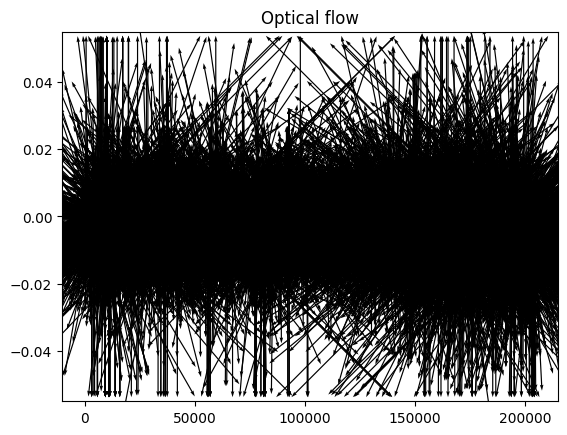

In [13]:
# Display optical flow
def display_optical_flow(u: np.ndarray, v: np.ndarray) -> None:
    """
    Display optical flow
    :param u: optical flow in x
    :param v: optical flow in y
    """
    plt.title("Optical flow")
    
    # plt.imshow(frame1)
    plt.quiver(u, v, scale=700)
    
    plt.show()

display_optical_flow(u, v)